In [9]:
import torch
from torch import nn
import torchvision
from torch.utils.data import Subset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cnn

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

val_idx = [i for i in range(7000)]
test_idx = [i for i in range(10_000)]

valset = torch.utils.data.Subset(testset, val_idx)
testset = torch.utils.data.Subset(testset, test_idx)


valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


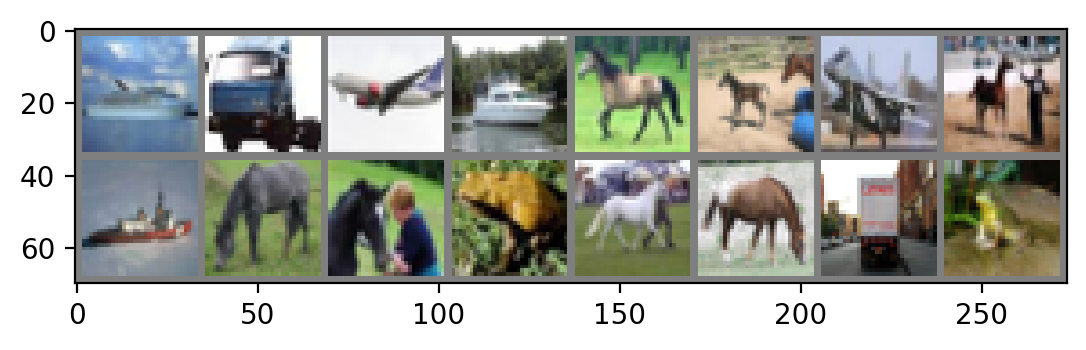

ship  truck plane ship  horse horse plane horse ship  horse horse frog  horse horse truck frog 


In [11]:

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [12]:
vgg = cnn.VGG(in_channels=3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=vgg.parameters(), momentum=0.9, lr=5e-3)
trainer = cnn.Trainer(model=vgg, train_dataloader=trainloader, val_dataloader=valloader, criterion=criterion, optimizer=optimizer, device=torch.device('cuda'), log_dir="check_overfits_small_train/")

In [13]:
trainer.train(epochs=20)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [21]:
vgg = cnn.VGG(in_channels=3)


c:\Users\frede\OneDrive\Documents\KTH_2022_2023\DD2424_DL_in_DS\Project\Cifar-10-CNN\cifar-10-cnn\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


torch.Size([4, 10])